# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [3]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-v0_8')

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
# basic cleaning function:
# ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

# def clean(text):
#     '''Simplified text cleaning function'''
#     stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#     text = text.lower()
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#     words = re.sub(r"[^a-z0-9\s]", '', text)
#     return [word for word in words if word not in stopwords]

In [5]:
# acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url)
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# drop out id column (arbitrary index)
df = df.drop(columns='id')

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_validate, test = train_test_split(df,
                                        random_state=1349,
                                        train_size=0.8,
                                       stratify=df.label)
train, validate = train_test_split(train_validate,
                                   random_state=1349,
                                   train_size=0.7,
                                  stratify=train_validate.label)

In [9]:
train.shape, validate.shape, test.shape

((3119, 2), (1338, 2), (1115, 2))

### If we look at this in the context of a classification problem,
we may ask:
 - What leads to a spam text?
 - What leads to a ham text?
 

In [ ]:
# lets clean that data

In [10]:
# let's get some sights on word frequency by taking 
# our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present
ham_df = train[train.label=='ham']

In [12]:
ham_words = clean(' '.join(train[train.label=='ham']['text']))
spam_words = clean(' '.join(train[train.label=='spam']['text']))
all_words = clean(' '.join(train['text']))

In [13]:
len(ham_words), len(spam_words), len(all_words)

(21681, 6815, 28496)

In [14]:
len(ham_words) + len(spam_words) == len(all_words)

True

In [15]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [16]:
ham_freq.head()

im      254
get     198
ok      158
go      148
know    142
Name: count, dtype: int64

In [17]:
spam_freq.head()

call    195
free    126
text     84
ur       81
txt      76
Name: count, dtype: int64

## Exploration

Represent text as word frequencies.

In [18]:
# concat all frequencies together into a dataframe
word_counts = pd.concat([ham_freq, spam_freq,all_freq], axis=1
         ).fillna(0
                 ).astype(int)
word_counts.columns = ['ham','spam','all']
word_counts.head()

,ham,spam,all
im,254,8,262
get,198,45,243
ok,158,3,161
go,148,20,168
know,142,16,158


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [19]:
word_counts.sort_values('all', ascending=False).head()

,ham,spam,all
call,125,195,320
im,254,8,262
get,198,45,243
ur,121,81,202
4,107,68,175


In [38]:
word_counts.sort_values(['ham','spam','all'], ascending=False).head()

,ham,spam,all
im,254,8,262
get,198,45,243
ok,158,3,161
go,148,20,168
know,142,16,158


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

<Axes: >

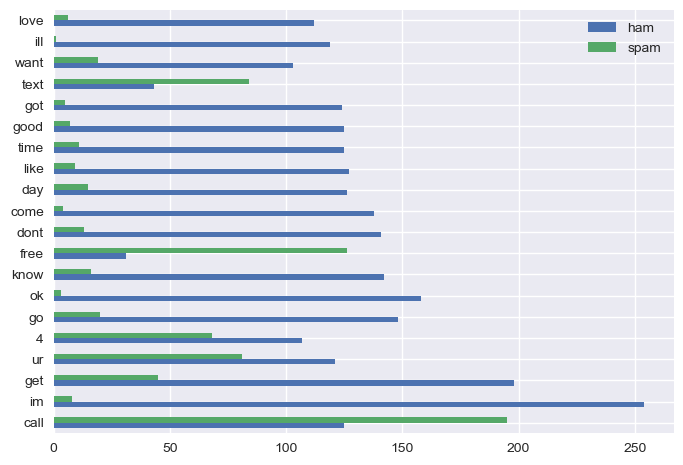

In [42]:
word_counts.sort_values('all', ascending=False
                       )[['ham','spam']].head(20).plot.barh()

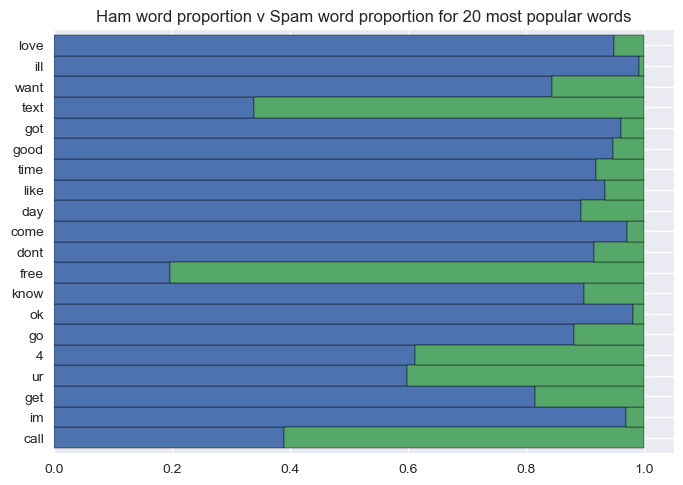

In [54]:
word_counts.sort_values('all', ascending=False
                       ).head(20).apply(
    lambda row: row/row['all'], axis=1
)[['ham','spam']].plot.barh(
    stacked=True, legend=False, ec='black', 
    width=1).set(title='Ham word proportion v Spam word proportion for 20 most popular words');
                                                         

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [55]:
# let's test this out on a sentence:
some_string = 'here is a thing to put into bigrams ok'

In [58]:
list(nltk.bigrams(some_string.split()))

[('here', 'is'),
 ('is', 'a'),
 ('a', 'thing'),
 ('thing', 'to'),
 ('to', 'put'),
 ('put', 'into'),
 ('into', 'bigrams'),
 ('bigrams', 'ok')]

**Be Careful!** Make sure you are making bigrams out of *words*.

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

<Axes: >

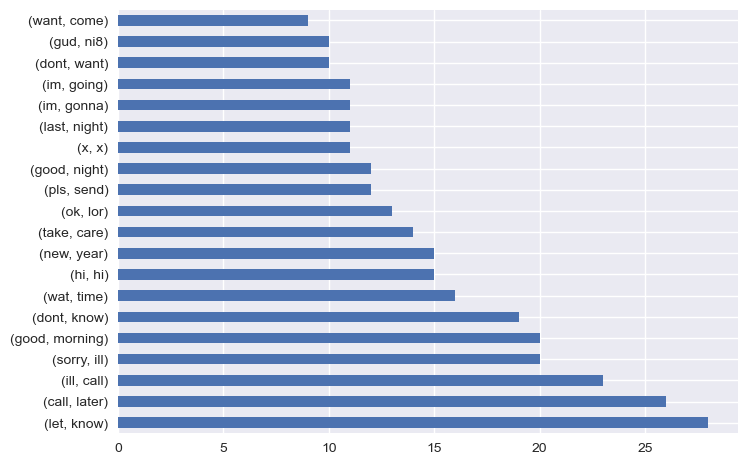

In [67]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(20).plot.barh()

In [72]:
# making other types of ngrams:
list(nltk.ngrams(some_string.split(), 6))

[('here', 'is', 'a', 'thing', 'to', 'put'),
 ('is', 'a', 'thing', 'to', 'put', 'into'),
 ('a', 'thing', 'to', 'put', 'into', 'bigrams'),
 ('thing', 'to', 'put', 'into', 'bigrams', 'ok')]

<Axes: >

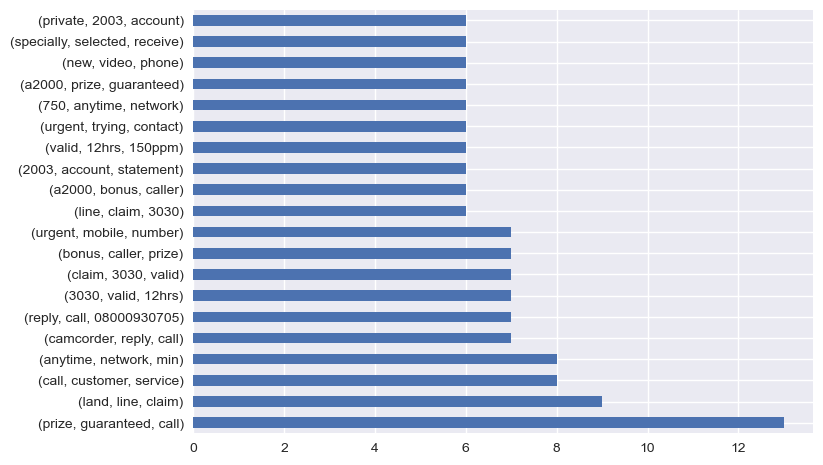

In [76]:
pd.Series(nltk.ngrams(spam_words, 3)
         ).value_counts().head(20).plot.barh()

In [87]:
ham_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(ham_words))]

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

In [20]:
from wordcloud import WordCloud

In [21]:
# wordcloud expects a single string
img = WordCloud(background_color='White',
         ).generate(' '.join(ham_words))

In [79]:
img

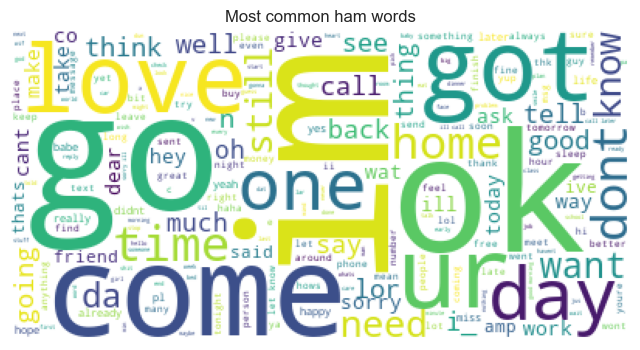

In [22]:
plt.imshow(img)
plt.axis('off')
plt.title('Most common ham words')
plt.show()

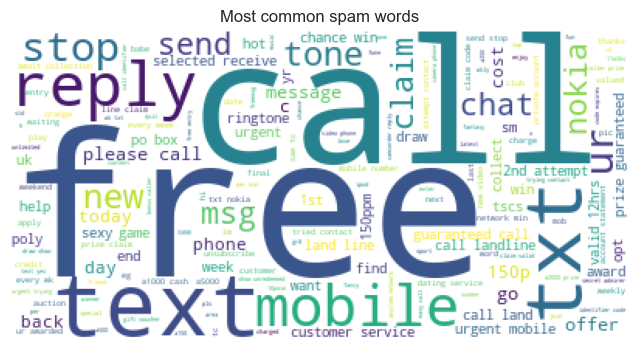

In [23]:
img = WordCloud(background_color='White',
         ).generate(' '.join(spam_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most common spam words')
plt.show()

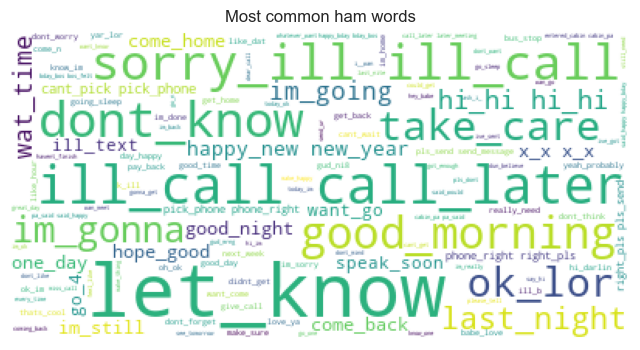

In [88]:
# wordcloud expects a single string
img = WordCloud(background_color='White',
         ).generate(' '.join(ham_grams))
plt.imshow(img)
plt.axis('off')
plt.title('Most common ham words')
plt.show()

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [89]:
# we apply our clean function, apply len chained on it
# if we did not want to clean this before
# word count, we would want to do a split on it


## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [24]:
import nltk.sentiment

In [25]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

In [92]:
sia.polarity_scores('Things are going really well!')

{'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'compound': 0.3989}

In [93]:
sia.polarity_scores('Things are going really awful!')

{'neg': 0.473, 'neu': 0.527, 'pos': 0.0, 'compound': -0.5551}

In [99]:
sia.polarity_scores('she is vegan :(')['compound']

-0.4404

Apply this to the text message data

In [27]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score
train['compound_sentiment'] = train['text'
                                   ].apply(
    lambda x: sia.polarity_scores(x)['compound'])

In [28]:
# is the mean and median values of sentiment score different for ham vs spam?
train.groupby('label')['compound_sentiment'].mean()

label
ham     0.148131
spam    0.454145
Name: compound_sentiment, dtype: float64

### Takeaways:
 - Spam messages seem to have roughly the same message length, where ham varies a lot.
 - Spam messages have a very positive sentiment
 - If we wanted to utilize these features for modeling, we would want to proceed forward with means testing to establish their viability

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)